# AI based video searching


## keypoint format : COCO human pose
- 17 joints

<img src="https://github.com/robertklee/COCO-Human-Pose/raw/main/figures/skeleton_442619_flip_107_labelled.png" alt="drawing" width="400"/>

In [4]:
names = ['head_center', 'head_right_upper', 'head_left_upper', 'head_right_lower', 'head_left_lower',
        'right_shoulder', 'left_shoulder', 'right_elbow', 'left_elbow', 'right_hand', 'left_hand',
        'right_pelvis', 'left_pevlis', 'right_knee', 'left_knee', 'right_foot', 'left_foot']
joint2name = {i:n for (i,n) in zip(range(17), names)}
joint2name

{0: 'head_center',
 1: 'head_right_upper',
 2: 'head_left_upper',
 3: 'head_right_lower',
 4: 'head_left_lower',
 5: 'right_shoulder',
 6: 'left_shoulder',
 7: 'right_elbow',
 8: 'left_elbow',
 9: 'right_hand',
 10: 'left_hand',
 11: 'right_pelvis',
 12: 'left_pevlis',
 13: 'right_knee',
 14: 'left_knee',
 15: 'right_foot',
 16: 'left_foot'}

In [6]:
import os, sys
from glob import glob
import copy

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler, RobustScaler

from scipy.stats import kurtosis
from scipy.stats import skew

sys.path.insert(0, "utils/")
from preprocess import get_bbox_max_width_height, get_stats, pose_with_topk_joints
from distance import cosine_dist_xy_flatten, cosine_dist_xy
from visualize import multi_displot
from scipy.spatial.distance import cosine

from matplotlib import pyplot as plt
import seaborn as sns

### load data

In [9]:
base_dir = 'samples/npy'
pose_paths = sorted(glob(os.path.join(base_dir,'*_pose.npy')))
bbox_paths = sorted(glob(os.path.join(base_dir,'*_bbox.npy')))

print(len(pose_paths), len(bbox_paths))

poses = [np.load(pose_paths[i], allow_pickle=True)[..., :2] for i in range(len(pose_paths))]
bboxes = [np.load(bbox_paths[i], allow_pickle=True) for i in range(len(bbox_paths))]

print(len(poses), len(bboxes))

35 35
35 35


In [10]:
DROP_OPTION1 = [1, 2, 3, 4]
DROP_OPTION2 = [7, 8]
DROP_OPTION3 = [5, 6, 11, 12]
DROP_OPTION4 = [1,2,3,4,5,6,7,8,11,12]
DROP_OPTION5 = [1,2,3,4,5,6,11,12]

# 7,8,9,10
DROP_OPTION_ARMS = [i for i in range(17) if i not in [7,8,9,10]] # 좌우 팔꿈치와 손 조인트 4개만 사용한다
DROP_OPTION_LEGS = [0,1,2,3,4,5,6,7,8,9,10,11,12] # 좌우 무릎과 발 조인트 (총4개)만 사용한다

### bbox scaling

In [ ]:
pose_dict = {}

for i, (ppath, bbox_path) in enumerate(zip(pose_paths, bbox_paths)):
    fname = os.path.basename(ppath).split('_')[0].split('-')[0]
    if fname not in pose_dict:
        pose_dict[fname] = {'x':None, 'y':None, 'xy':None}

    if bboxes[i].dtype == 'object':
      bbox = np.concatenate(list(bboxes[i]), axis=0).reshape(-1, 1, 4)
    else:
      bbox = bboxes[i]

    bbox_xmins, bbox_ymins = bbox[..., 0], bbox[..., 1]
    bbox_width, bbox_height = bbox[..., 2] - bbox[..., 0], bbox[..., 3] - bbox[..., 1]
    bbox_max_width, bbox_max_height = get_bbox_max_width_height(bbox)

    ppose = poses[i]
    ppose_x = ppose[..., 0] - bbox_xmins
    ppose_y = ppose[..., 1] - bbox_ymins
    ppose_x /= bbox_max_width
    ppose_y /= bbox_max_height

    ppose_xy = np.stack([ppose_x, ppose_y], axis=-1)
    ppose_xy_reshape = np.stack([ppose_x, ppose_y], axis=-1).reshape(-1, 2)

    # drop index
    # ppose_xy_option1 = np.delete(ppose_xy, np.s_[DROP_OPTION1], axis=1)
    # ppose_xy_option2 = np.delete(ppose_xy, np.s_[DROP_OPTION2], axis=1)
    # ppose_xy_option3 = np.delete(ppose_xy, np.s_[DROP_OPTION3], axis=1)
    ppose_xy_option4 = np.delete(ppose_xy, np.s_[DROP_OPTION4], axis=1)
    # ppose_xy_option5 = np.delete(ppose_xy, np.s_[DROP_OPTION5], axis=1)
    # pose_dict[fname]['xy_opt1'] = ppose_xy_option1.reshape(-1, 2)
    # pose_dict[fname]['xy_opt2'] = ppose_xy_option2.reshape(-1, 2)
    # pose_dict[fname]['xy_opt3'] = ppose_xy_option3.reshape(-1, 2)
    pose_dict[fname]['xy_opt4'] = ppose_xy_option4
    pose_dict[fname]['xy_opt4_reshape'] = ppose_xy_option4.reshape(-1, 2)
    # pose_dict[fname]['xy_opt5'] = ppose_xy_option5.reshape(-1, 2)
    
    # ppose_xy_option1_nohead = np.delete(ppose_xy, np.s_[[0] + DROP_OPTION1], axis=1)
    # ppose_xy_option4_nohead = np.delete(ppose_xy, np.s_[[0] + DROP_OPTION4], axis=1)
    # ppose_xy_option5_nohead = np.delete(ppose_xy, np.s_[[0] + DROP_OPTION5], axis=1)
    # pose_dict[fname]['xy_opt1_nohead'] = ppose_xy_option1_nohead.reshape(-1, 2)
    # pose_dict[fname]['xy_opt4_nohead'] = ppose_xy_option4_nohead.reshape(-1, 2)
    # pose_dict[fname]['xy_opt5_nohead'] = ppose_xy_option5_nohead.reshape(-1, 2)

    # ppose_xy_option_arm = np.delete(ppose_xy, np.s_[DROP_OPTION_ARMS], axis=1)
    # ppose_xy_option_leg = np.delete(ppose_xy, np.s_[DROP_OPTION_LEGS], axis=1)
    # pose_dict[fname]['xy_opt_arm'] = ppose_xy_option_arm.reshape(-1, 2)
    # pose_dict[fname]['xy_opt_leg'] = ppose_xy_option_leg.reshape(-1, 2)
    
    pose_dict[fname]['x'], pose_dict[fname]['y'], pose_dict[fname]['xy'], pose_dict[fname]['xy_reshape'] = ppose_x, ppose_y, ppose_xy, ppose_xy_reshape
        
    print(fname, 'frames:', len(ppose_x), ppose.shape)#, sorted(topk_idx))

In [13]:
# relative padding test
pose_dict_v2 = {}

for i, (ppath, bbox_path) in enumerate(zip(pose_paths, bbox_paths)):
   fname = os.path.basename(ppath).split('_')[0].split('-')[0]
   if fname not in pose_dict_v2:
      pose_dict_v2[fname] = {'x':None, 'y':None, 'xy':None, 'xy_flatten':None}
   
   if bboxes[i].dtype == 'object':
      bbox = np.concatenate(list(bboxes[i]), axis=0).reshape(-1, 1, 4)
   else:
      bbox = bboxes[i]

   bbox_xmins, bbox_ymins = bbox[..., 0], bbox[..., 1]
   bbox_width, bbox_height = bbox[..., 2] - bbox[..., 0], bbox[..., 3] - bbox[..., 1]
   
   bbox_max_width, bbox_max_height = get_bbox_max_width_height(bbox)

   ppose = poses[i]
   ppose_x = ppose[..., 0] - bbox_xmins
   ppose_y = ppose[..., 1] - bbox_ymins
   ppose_x_maxes = np.max(ppose_x, axis=1)
   ppose_y_maxes = np.max(ppose_y, axis=1)

   x_padding = np.array([(bbox_max_width - xmax) / 2.0 for xmax in ppose_x_maxes])
   y_padding = np.array([(bbox_max_height - ymax) / 2.0 for ymax in ppose_y_maxes])

   ppose_x += x_padding.reshape(-1, 1)
   ppose_y += y_padding.reshape(-1, 1)

   ppose_x /= bbox_max_width
   ppose_y /= bbox_max_height

   ppose_xy = np.stack([ppose_x, ppose_y], axis=-1)
   ppose_xy_reshape = np.stack([ppose_x, ppose_y], axis=-1).reshape(-1, 2)

   ppose_xy_option4 = np.delete(ppose_xy, np.s_[DROP_OPTION4], axis=1)
   pose_dict_v2[fname]['xy_opt4'] = ppose_xy_option4
   pose_dict_v2[fname]['xy_opt4_reshape'] = ppose_xy_option4.reshape(-1, 2)

   pose_dict_v2[fname]['x'], pose_dict_v2[fname]['y'], pose_dict_v2[fname]['xy'], pose_dict_v2[fname]['xy_reshape'] = ppose_x, ppose_y, ppose_xy, ppose_xy_reshape
   print(fname, 'frames:', len(ppose_x), ppose.shape)#, sorted(topk_idx))

aespa1 frames: 7213 (7213, 17, 2)
aespa2 frames: 7196 (7196, 17, 2)
aespa3 frames: 2577 (2577, 17, 2)
aespa4 frames: 7063 (7063, 17, 2)
aespa5 frames: 2784 (2784, 17, 2)
bts1 frames: 7033 (7033, 17, 2)
bts2 frames: 6438 (6438, 17, 2)
bts3 frames: 3496 (3496, 17, 2)
bts4 frames: 6957 (6957, 17, 2)
bts5 frames: 7720 (7720, 17, 2)
bts6 frames: 7261 (7261, 17, 2)
bts7 frames: 5196 (5196, 17, 2)
itzy10 frames: 6130 (6130, 17, 2)
itzy11 frames: 2011 (2011, 17, 2)
itzy1 frames: 2003 (2003, 17, 2)
itzy2 frames: 2899 (2899, 17, 2)
itzy3 frames: 4188 (4188, 17, 2)
itzy4 frames: 8583 (8583, 17, 2)
itzy5 frames: 5342 (5342, 17, 2)
itzy6 frames: 1951 (1951, 17, 2)
itzy7 frames: 2054 (2054, 17, 2)
itzy8 frames: 4506 (4506, 17, 2)
itzy9 frames: 2115 (2115, 17, 2)
jenny1 frames: 5090 (5090, 17, 2)
jenny2 frames: 5052 (5052, 17, 2)
jenny3 frames: 1882 (1882, 17, 2)
jenny4 frames: 4085 (4085, 17, 2)
jenny5 frames: 4029 (4029, 17, 2)
twice1 frames: 4618 (4618, 17, 2)
twice2 frames: 6549 (6549, 17, 2)
twi

In [43]:
pose_dict.keys()

dict_keys(['aespa1', 'aespa2', 'aespa3', 'aespa4', 'aespa5', 'bts1', 'bts2', 'bts3', 'bts4', 'bts5', 'bts6', 'bts7', 'itzy10', 'itzy11', 'itzy1', 'itzy2', 'itzy3', 'itzy4', 'itzy5', 'itzy6', 'itzy7', 'itzy8', 'itzy9', 'jenny1', 'jenny2', 'jenny3', 'jenny4', 'jenny5', 'twice1', 'twice2', 'twice3', 'twice4', 'twice5', 'twice6', 'twice7'])

### create tree

In [20]:
label_map = {v:i for i,v in enumerate(pose_dict.keys())}
label_map_inv = {i:v for i,v in enumerate(pose_dict.keys())}

for label in label_map.keys():
    for pose in pose_dict[label]['xy']:
        label_num = label_map[label]
        # pose_hashed = hash_video_svd_wavelet_labeled(pose, label_num)
        # pose_hashed = hash_video_svd_labeled(pose, label_num, target_frame=256, group_num=16)
        # pose_arrs[label]['pose_hash'].append(pose_hashed)

In [21]:
concat_default_v1, concat_default_v2 = [], []
concat_opt4_v1, concat_opt4_v2 = [], []

for cat in label_map.keys():
    concat_default_v1.append(pose_dict[cat]['xy'])
    concat_default_v2.append(pose_dict_v2[cat]['xy'])

    # concat_opt1.append(pose_dict[cat]['xy_opt1'])
    concat_opt4_v1.append(pose_dict[cat]['xy_opt4'])
    concat_opt4_v2.append(pose_dict_v2[cat]['xy_opt4'])
    # concat_opt5.append(pose_dict[cat]['xy_opt5'])

    # # concat_opt1_nohead.append(pose_dict[cat]['xy_opt1_nohead'])
    # concat_opt4_nohead.append(pose_dict[cat]['xy_opt4_nohead'])
    # concat_opt5_nohead.append(pose_dict[cat]['xy_opt5_nohead'])

    # concat_opt_arm.append(pose_dict[cat]['xy_opt_arm'])
    # concat_opt_leg.append(pose_dict[cat]['xy_opt_leg'])

    # if type(concat) == int:
    #     concat = pose_dict[cat]['xy']
    #     # concat = [pose_arrs[cat]['pose'][0].flatten()]
    # else:
    #     concat = np.concatenate([concat, pose_dict[cat]['xy']])
        # concat = np.concatenate([concat, [pose_arrs[cat]['pose'][0].flatten()]])
# len(concat_default), len(concat_opt4), len(concat_opt4_nohead), len(concat_opt5), len(concat_opt5_nohead)

In [34]:
import vptree
from scipy import spatial

# Build tree in O(n log n) time complexity.
tree_default_v1 = vptree.VPTree(concat_default_v1, cosine_dist_xy_flatten)
tree_default_v2 = vptree.VPTree(concat_default_v2, cosine_dist_xy_flatten)
tree_opt4_v1 = vptree.VPTree(concat_opt4_v1, cosine_dist_xy_flatten)
tree_opt4_v2 = vptree.VPTree(concat_opt4_v2, cosine_dist_xy_flatten)

# tree_opt1 = vptree.VPTree(concat_opt1, cosine_dist_xy_flatten_vptree)
# tree_opt4 = vptree.VPTree(concat_opt4, cosine_dist_xy_flatten_vptree)
# tree_opt5 = vptree.VPTree(concat_opt5, cosine_dist_xy_flatten_vptree)
# # tree_opt1_nohead = vptree.VPTree(concat_opt1_nohead, cosine_dist_xy_flatten_vptree)
# tree_opt4_nohead = vptree.VPTree(concat_opt4_nohead, cosine_dist_xy_flatten_vptree)
# tree_opt5_nohead = vptree.VPTree(concat_opt5_nohead, cosine_dist_xy_flatten_vptree)

# tree_opt_arm = vptree.VPTree(concat_opt_arm, cosine_dist_xy_flatten_vptree)
# tree_opt_leg = vptree.VPTree(concat_opt_leg, cosine_dist_xy_flatten_vptree)

coord_names = ['xy', 'xy_opt4']
tree_dict_v1 = {name:obj for (name, obj) in zip(coord_names, [tree_default_v1, tree_opt4_v1])}
tree_dict_v2 = {name:obj for (name, obj) in zip(coord_names, [tree_default_v2, tree_opt4_v2])}

In [35]:
def get_label_from_query_result(res, pose_dict, label_map, target='xy'):
    out = {}
    for r in res:
        dist, arr = r[0], r[1]
        keys = list(label_map.keys())
        for key in keys:
            arr2 = pose_dict[key][target]
            try:
                if (arr == arr2).all():
                    out[dist] = key
            except:
                pass
    return out

### query test

In [47]:
# Query single point.
QUERY_CATEGORY = 'aespa1'
QOORD = 'xy'

tree = tree_dict_v1[QOORD]
posedict = pose_dict
###########################################################

result = tree.get_n_nearest_neighbors(posedict[QUERY_CATEGORY][QOORD], 10)
get_label_from_query_result(result, posedict, label_map, QOORD)

{0.0: 'aespa1',
 0.051982983944343975: 'aespa4',
 0.05296148098134468: 'aespa2',
 0.05542951373246496: 'itzy5',
 0.055744065312109625: 'itzy6',
 0.05596436321871423: 'itzy1',
 0.05634231447361626: 'itzy9',
 0.056716960143727735: 'jenny3',
 0.059179583142256464: 'jenny4',
 0.06055804788588015: 'bts1'}

In [37]:
# Query single point.
QUERY_CATEGORY = 'aespa1'
QOORD = 'xy_opt4'

tree = tree_dict_v1[QOORD]
posedict = pose_dict
###########################################################

result = tree.get_n_nearest_neighbors(posedict[QUERY_CATEGORY][QOORD], 10)
get_label_from_query_result(result, posedict, label_map, QOORD)

{0.0: 'aespa1',
 0.044524505329860076: 'aespa4',
 0.04574755985358314: 'aespa2',
 0.049457214418232365: 'itzy5',
 0.05020849453952836: 'itzy1',
 0.05042639009070615: 'itzy9',
 0.05055050434714503: 'jenny3',
 0.050871698143461375: 'itzy6',
 0.051052619760828866: 'jenny4',
 0.05256787230429549: 'bts1'}

In [48]:
# Query single point.
QUERY_CATEGORY = 'aespa1'
QOORD = 'xy'

tree = tree_dict_v2[QOORD]
posedict = pose_dict_v2
###########################################################

result = tree.get_n_nearest_neighbors(posedict[QUERY_CATEGORY][QOORD], 10)
get_label_from_query_result(result, posedict, label_map, QOORD)

{0.0: 'aespa1',
 0.017438055561506793: 'aespa2',
 0.01788967967781263: 'jenny4',
 0.01789054491169506: 'jenny5',
 0.01834855882888664: 'aespa4',
 0.018697612354343307: 'itzy9',
 0.018755340460394287: 'jenny3',
 0.019045442985114458: 'itzy1',
 0.01927802421560476: 'itzy5',
 0.019445195337394527: 'jenny2'}

In [49]:
# Query single point.
QUERY_CATEGORY = 'aespa1'
QOORD = 'xy_opt4'

tree = tree_dict_v2[QOORD]
posedict = pose_dict_v2
###########################################################

result = tree.get_n_nearest_neighbors(posedict[QUERY_CATEGORY][QOORD], 10)
get_label_from_query_result(result, posedict, label_map, QOORD)

{0.0: 'aespa1',
 0.019040242740891777: 'aespa2',
 0.02019614893061683: 'jenny5',
 0.020526110573508283: 'aespa4',
 0.021294062282219084: 'jenny4',
 0.021796881418778224: 'itzy5',
 0.02203860072025321: 'itzy9',
 0.02257837854958178: 'itzy1',
 0.022680943996641556: 'jenny3',
 0.022730774683236032: 'itzy4'}

In [50]:
# Query single point.
QUERY_CATEGORY = 'itzy1'
QOORD = 'xy_opt4'

tree = tree_dict_v2[QOORD]
posedict = pose_dict_v2
###########################################################

result = tree.get_n_nearest_neighbors(posedict[QUERY_CATEGORY][QOORD], 10)
get_label_from_query_result(result, posedict, label_map, QOORD)

{0.0: 'itzy1',
 0.008379396025482544: 'itzy9',
 0.012795603427296576: 'itzy5',
 0.016094583366679127: 'itzy6',
 0.01617150851232463: 'itzy3',
 0.016923759022106744: 'jenny5',
 0.0176134461402091: 'itzy4',
 0.01778180271699581: 'jenny4',
 0.018935985021912294: 'jenny1',
 0.01905613556354535: 'itzy11'}

In [51]:
# Query single point.
QUERY_CATEGORY = 'bts1'
QOORD = 'xy_opt4'

tree = tree_dict_v2[QOORD]
posedict = pose_dict_v2
###########################################################

result = tree.get_n_nearest_neighbors(posedict[QUERY_CATEGORY][QOORD], 10)
get_label_from_query_result(result, posedict, label_map, QOORD)

{0.0: 'bts1',
 0.015186065389912184: 'bts3',
 0.017637390515160445: 'bts4',
 0.01861261497684319: 'bts6',
 0.0186753919633742: 'jenny4',
 0.018896432545056463: 'jenny5',
 0.01910497812424594: 'bts2',
 0.019382780298008884: 'itzy5',
 0.020287277068369303: 'bts7',
 0.02081846099823026: 'aespa2'}

### visualize

In [ ]:
# OPTION1 = [a for a in range(16) if a not in DROP_OPTION1]
# # OPTION2 = [a for a in range(16) if a not in DROP_OPTION2]
# # OPTION3 = [a for a in range(16) if a not in DROP_OPTION3]
# OPTION4 = [a for a in range(16) if a not in DROP_OPTION4]
# OPTION5 = [a for a in range(16) if a not in DROP_OPTION5]

# OPTION1_nohead = OPTION1[1:]
# OPTION4_nohead = OPTION4[1:]
# OPTION5_nohead = OPTION5[1:]

# OPTION1, OPTION4, OPTION5, OPTION1_nohead

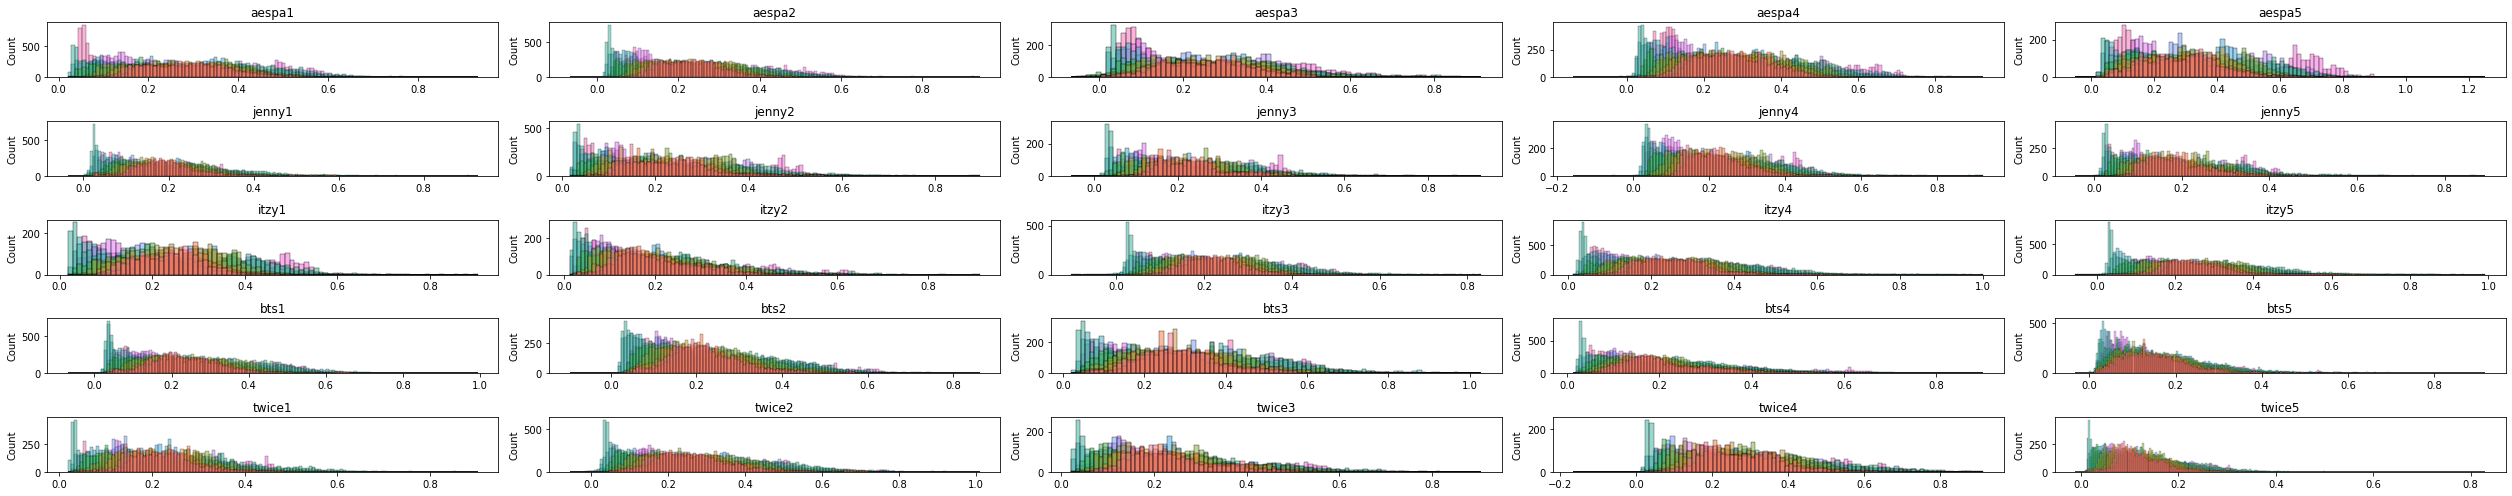

In [30]:
multi_displot(pose_dict, 
            [[f'{name}{i+1}' for i in range(5)] for name in ['aespa', 'jenny', 'itzy', 'bts', 'twice']], 
            opt=None, figsize=(35, 7), coord='x')

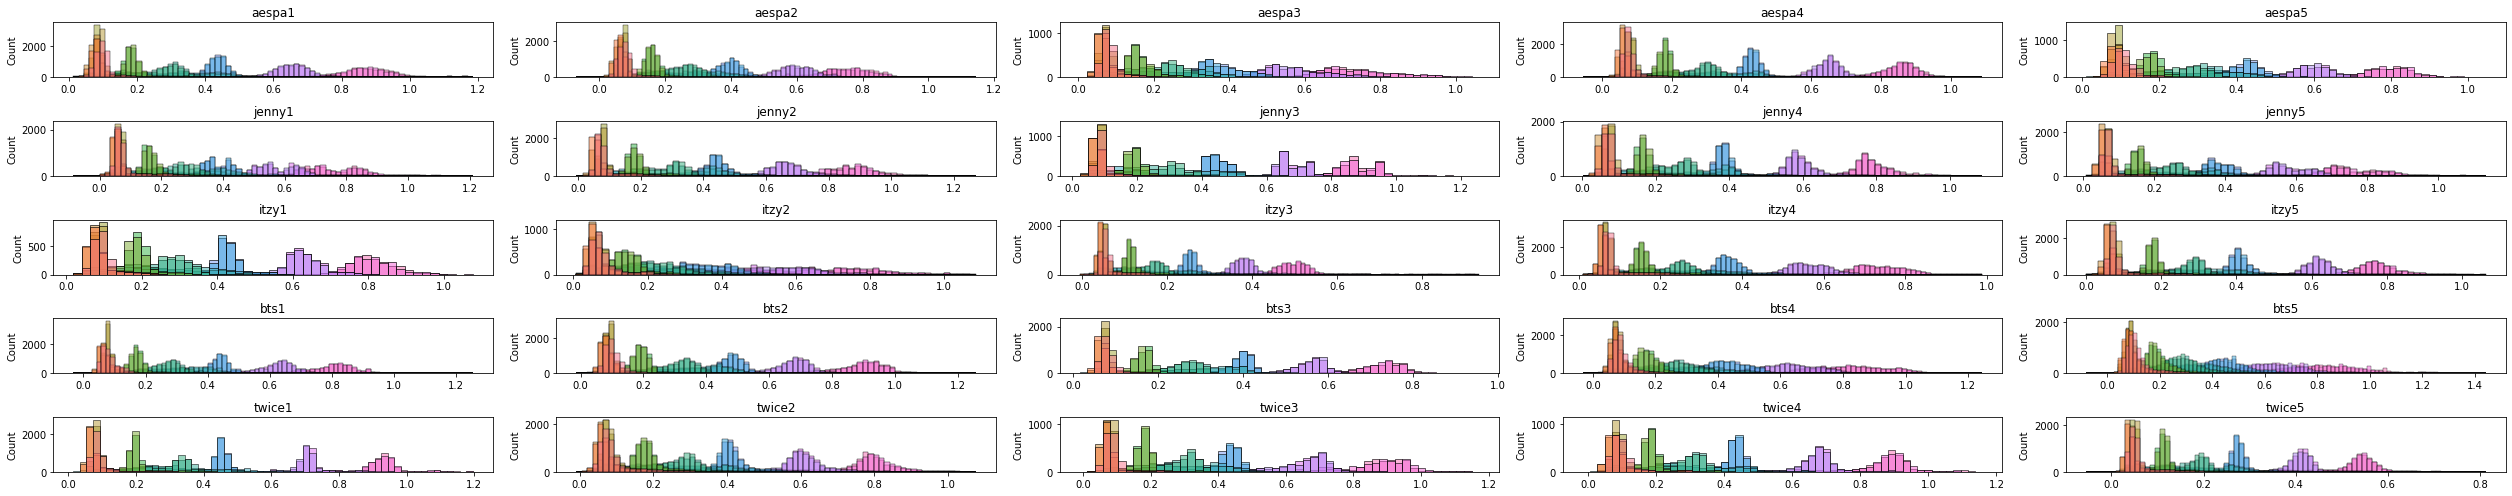

In [31]:
multi_displot(pose_dict, 
            [[f'{name}{i+1}' for i in range(5)] for name in ['aespa', 'jenny', 'itzy', 'bts', 'twice']], 
            opt=None, figsize=(35, 7), coord='y')

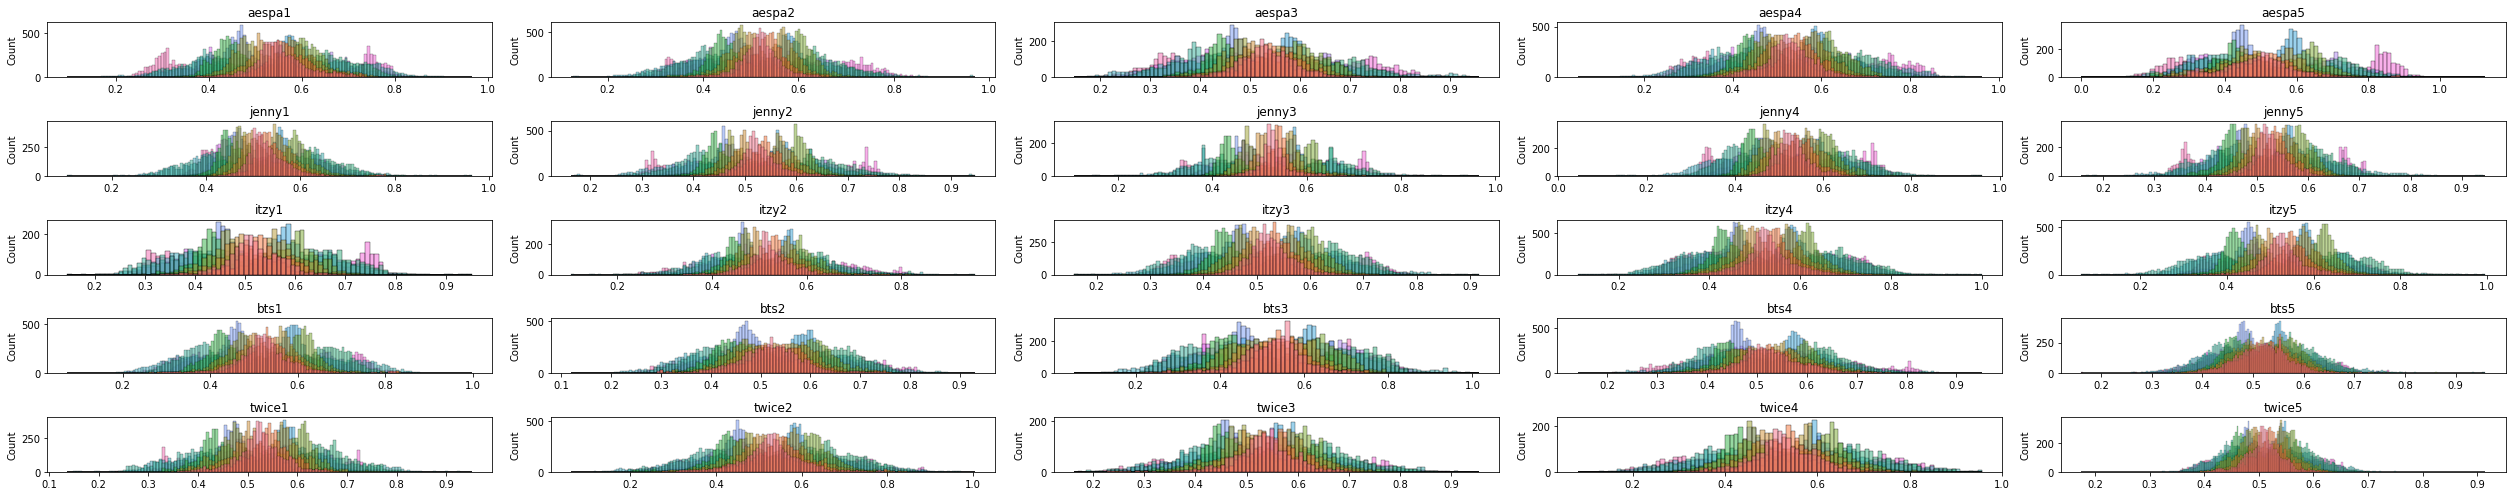

In [32]:
multi_displot(pose_dict_v2, 
            [[f'{name}{i+1}' for i in range(5)] for name in ['aespa', 'jenny', 'itzy', 'bts', 'twice']], 
            opt=None, figsize=(35, 7), coord='x')

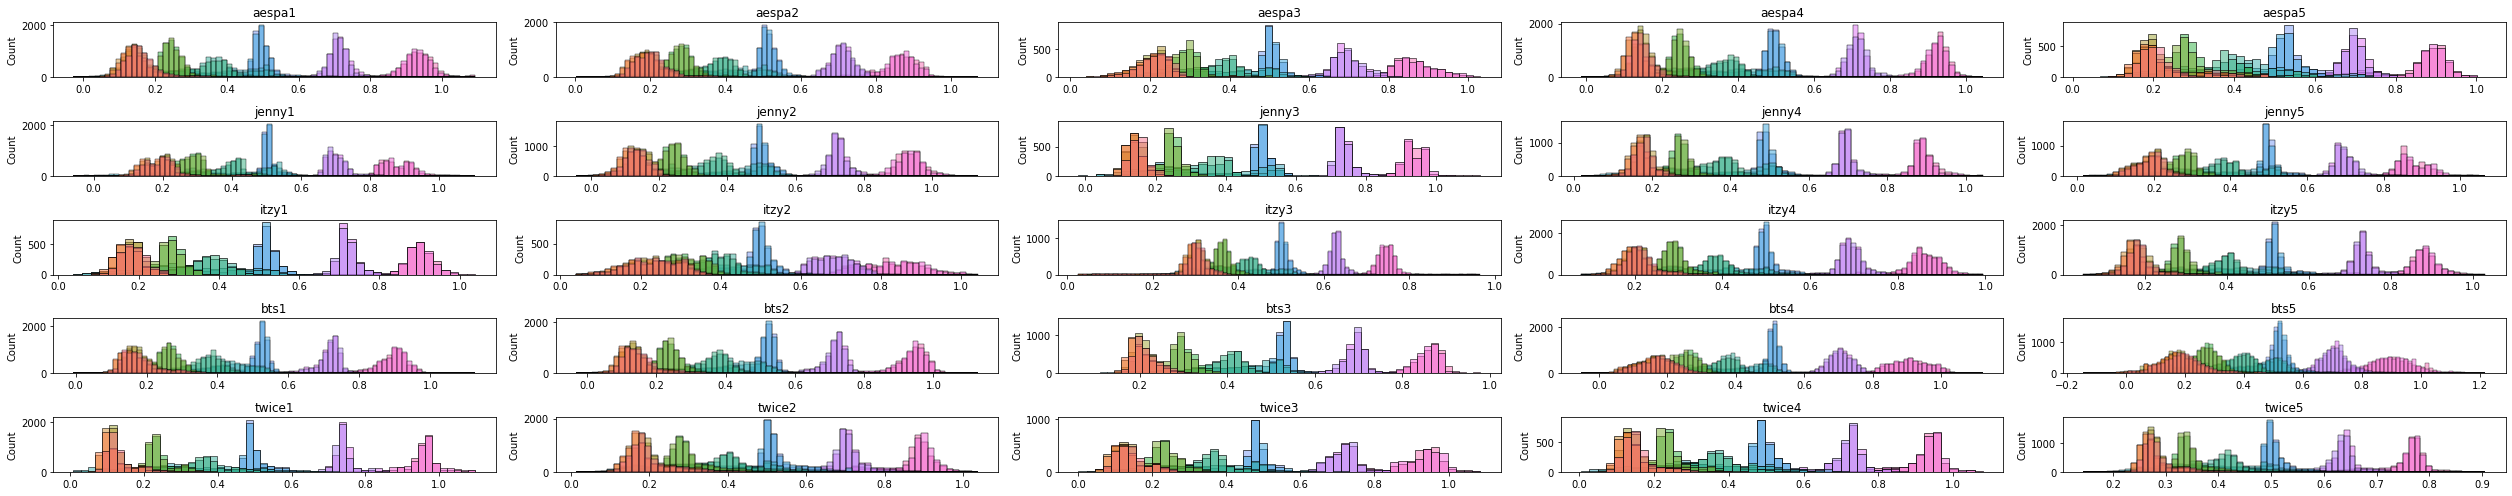

In [33]:
multi_displot(pose_dict_v2, 
            [[f'{name}{i+1}' for i in range(5)] for name in ['aespa', 'jenny', 'itzy', 'bts', 'twice']], 
            opt=None, figsize=(35, 7), coord='y')